# [Survival Analysis](https://en.wikipedia.org/wiki/Survival_analysis)

from : https://www.pymc.io/projects/examples/en/latest/survival_analysis/survival_analysis.html

## Theory

If the random variable $T$ is the time to the event we are studying, survival analysis is primarily concerned with the survival function: 
$$
S(t) = Pr(T > t) = 1 - F(t)
$$

Where $F(t)$ is the cumulative distribution function of $T$.

The survival function is the probability that the event will occur by time $t$ and is express in terms of [hazard rate](https://en.wikipedia.org/wiki/Survival_analysis#Hazard_function_and_cumulative_hazard_function), $\lambda(t)$, which is the instantaneous probability that the event will occur by time $t$ given that it has not already occurred by time $t$.

$$
\lambda(t) = \lim_{\Delta t \to 0} \frac{Pr(t < T > t + \Delta t | T > t)}{\Delta t}
$$

Which can be simplified to
$$
\lambda(t) = \frac{S'(t)}{S(t)}
$$

Solving this differential equation for the survival function shows that:

$$
S(t) =  exp(-\int_0^t \lambda(s) ds)
$$

This representation of the survival function shows that the cumulative hazard function is:

$$
\Lambda(t) = \int_0^t \lambda(s) ds
$$

An important, but subtle, point in survival analysis is [censoring](https://en.wikipedia.org/wiki/Survival_analysis#Censoring). 

## Bayesian proportional hazards model
Perhaps the most commonly used risk regression model is [Cox’s proportional hazards model(https://en.wikipedia.org/wiki/Proportional_hazards_model)]. In this model, if we have covariates $x$ and regression coefficients $\beta$, the hazard rate is modeled as :

$$
\lambda(t) = \lambda_0(t)exp(x\beta)
$$

Here $\lambda_0(t)$ is the baseline hazard rate which is independent of the covariates $x$.
In order to perform Bayesian inference with the Cox model, we must specify priors on $\beta$ and $\lambda_0(t)$:
$$\beta \sim N(\mu_\beta, \sigma^2_\beta)$$
$$\mu_\beta \sim Nomral(0, 10^2)$$ 
$$\sigma^2_\beta \sim Uniform(0,10)$$

$\lambda_0(t)$ is set as a semiparametric prior, a constant function, which require to partition the time range into intervals. This requires to choose priors for the $N-1$ intervals $\lambda_j$. $\lambda_j$ is usually a [Weibull distribution](https://en.wikipedia.org/wiki/Weibull_distribution) or a [Gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution).


The key observation is that the piecewise-constant proportional hazard model is closely related to a Poisson regression model. (The models are not identical, but their likelihoods differ by a factor that depends only on the observed data and not the parameters $\beta$ and $\lambda_j$.
We define indicator variables based on whether the $i$-th subject died in the $j$-th interval:

$$
d_{ij} = \begin{cases} 
1 & \text{if subject } i \text{ died in interval } j, \\
0 & \text{otherwise.}
\end{cases}
$$

We also define $t_{i,j}$ to be the amount of time the $i$-th subject was at risk in the $j$-th interval.


## Code

jax.local_device_count 32


sample: 100%|██████████| 1000/1000 [00:11<00:00, 89.73it/s, 511 steps of size 6.30e-03. acc. prob=0.91] 
/home/sosa/.local/lib/python3.10/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/home/sosa/.local/lib/python3.10/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/home/sosa/.local/lib/python3.10/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi

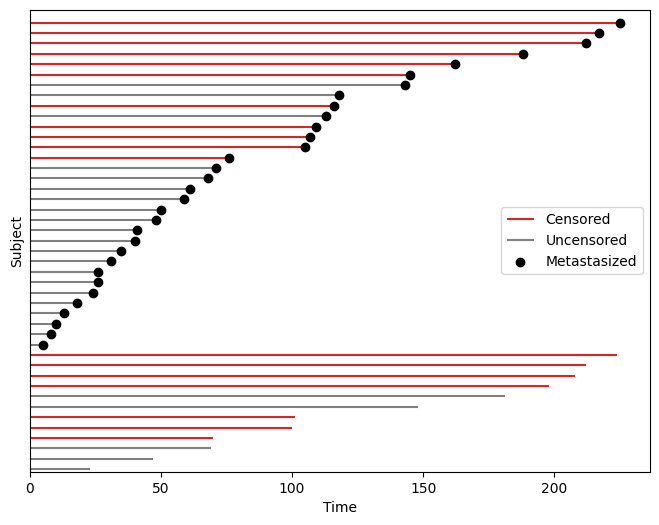

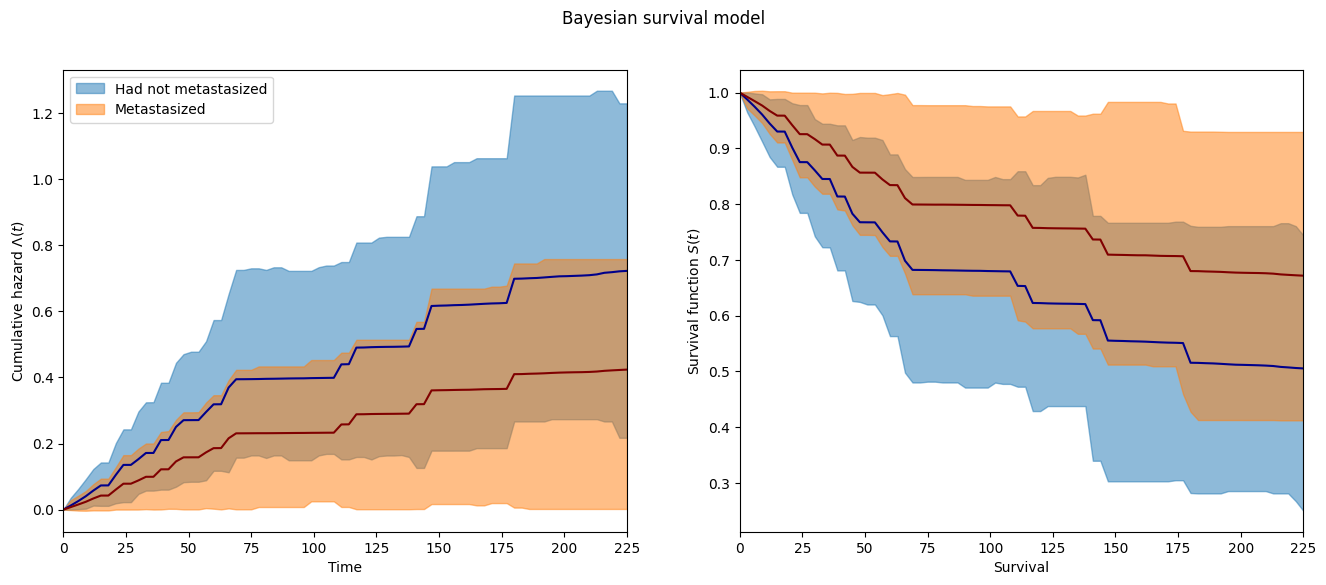

In [2]:
import os
import sys
newPath = os.path.dirname(os.path.abspath(""))
if newPath not in sys.path:
    sys.path.append(newPath)

from main import *
# Setup device------------------------------------------------
m = bi(platform='cpu')

# Import Data & Data Manipulation ------------------------------------------------
m.data('data/mastectomy.csv', sep=',') # Import

m.df.metastasized = (m.df.metastasized == "yes").astype(np.int64)
m.df.event = jnp.array(m.df.event.values, dtype=jnp.int32)
m.surv_object(time='time', event='event', cov='metastasized', interval_length=3)

# Plot censoring ------------------------------------------------
m.plot_censoring(cov='metastasized')

# Model ------------------------------------------------
def model(intervals, death, metastasized, exposure):
    # Parameters priors distributions-------------------------
    ## Base hazard distribution
    lambda0 = bi.dist.gamma(0.01, 0.01, shape= intervals.shape, name = 'lambda0')
    ## Covariate effect distribution
    beta = bi.dist.normal(0, 1000, shape = (1,),  name='beta')
    ## Likelihood
    ### Compute hazard rate based on covariate effect
    lambda_ = m.hazard_rate(cov = metastasized, beta = beta, lambda0 = lambda0)
    ### Compute exposure rates
    mu = exposure * lambda_

    # Likelihood calculation
    y = lk('obs', Poisson(mu + jnp.finfo(mu.dtype).tiny), obs = death)

m.run(model, num_samples=500) 

m.summary()

m.plot_surv()